# Regression

In [1]:
! pip install tensorflow==2.15.0

In [2]:
import tensorflow as tf

2024-02-24 15:39:25.314161: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-02-24 15:39:25.315545: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2024-02-24 15:39:25.334324: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-02-24 15:39:25.334350: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-02-24 15:39:25.334936: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to

## Get, clean, split and inspect the data

In [3]:
URL = 'http://archive.ics.uci.edu/ml/machine-learning-databases/auto-mpg/auto-mpg.data'
COLUMNS_NAMES = ['MPG', 'Cylinders', 'Displacement', 'Horsepower', 'Weight',
                'Acceleration', 'Model Year', 'Origin']


In [4]:
import pandas as pd

raw_dataset = pd.read_csv(URL, 
                          names=COLUMNS_NAMES, 
                          na_values='?', 
                          comment='\t', 
                          sep=' ', 
                          skipinitialspace=True)

raw_dataset.head()

,MPG,Cylinders,Displacement,Horsepower,Weight,Acceleration,Model Year,Origin
0,18.0,8,307.0,130.0,3504.0,12.0,70,1
1,15.0,8,350.0,165.0,3693.0,11.5,70,1
2,18.0,8,318.0,150.0,3436.0,11.0,70,1
3,16.0,8,304.0,150.0,3433.0,12.0,70,1
4,17.0,8,302.0,140.0,3449.0,10.5,70,1


In [5]:
dataset = raw_dataset.copy()

dataset.tail()

,MPG,Cylinders,Displacement,Horsepower,Weight,Acceleration,Model Year,Origin
393,27.0,4,140.0,86.0,2790.0,15.6,82,1
394,44.0,4,97.0,52.0,2130.0,24.6,82,2
395,32.0,4,135.0,84.0,2295.0,11.6,82,1
396,28.0,4,120.0,79.0,2625.0,18.6,82,1
397,31.0,4,119.0,82.0,2720.0,19.4,82,1


In [6]:
dataset.isna().sum()

MPG             0
Cylinders       0
Displacement    0
Horsepower      6
Weight          0
Acceleration    0
Model Year      0
Origin          0
dtype: int64

In [7]:
dataset = dataset.dropna()

dataset.isna().sum()

MPG             0
Cylinders       0
Displacement    0
Horsepower      0
Weight          0
Acceleration    0
Model Year      0
Origin          0
dtype: int64

In [8]:
dataset['Origin'] = dataset['Origin'].map({1: 'USA',
                                           2: 'Europe',
                                           3: 'Japan'})

In [9]:
dataset = pd.get_dummies(dataset, 
                         columns=['Origin'], 
                         prefix='', 
                         prefix_sep='')

dataset.tail()

,MPG,Cylinders,Displacement,Horsepower,Weight,Acceleration,Model Year,Europe,Japan,USA
393,27.0,4,140.0,86.0,2790.0,15.6,82,False,False,True
394,44.0,4,97.0,52.0,2130.0,24.6,82,True,False,False
395,32.0,4,135.0,84.0,2295.0,11.6,82,False,False,True
396,28.0,4,120.0,79.0,2625.0,18.6,82,False,False,True
397,31.0,4,119.0,82.0,2720.0,19.4,82,False,False,True


In [10]:
SEED = 42

train_dataset = dataset.sample(frac=.8, random_state=SEED)
test_dataset = dataset.drop(train_dataset.index)

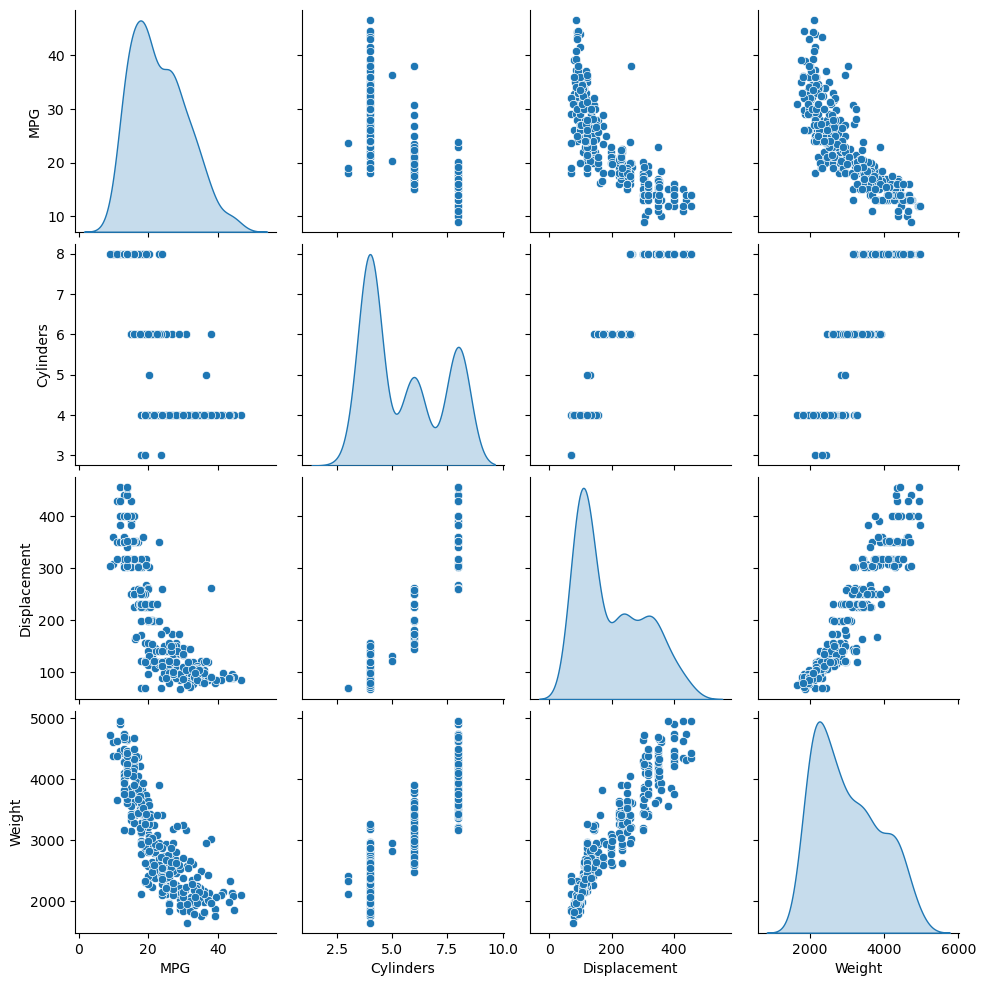

In [11]:
import seaborn as sns

sns.pairplot(train_dataset[['MPG', 'Cylinders', 'Displacement', 'Weight']], 
             diag_kind='kde')

In [12]:
train_dataset.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
MPG,314.0,23.153822,7.861854,9.0,17.000,22.0,28.075,46.6
Cylinders,314.0,5.531847,1.729449,3.0,4.000,4.0,8.000,8.0
Displacement,314.0,197.855096,106.501896,68.0,105.000,151.0,302.000,455.0
Horsepower,314.0,105.971338,39.636557,46.0,76.000,95.0,130.000,230.0
Weight,314.0,3005.745223,859.060925,1649.0,2231.000,2831.5,3641.750,4955.0
Acceleration,314.0,15.510828,2.803560,8.0,13.625,15.5,17.000,24.8
Model Year,314.0,75.910828,3.688989,70.0,73.000,76.0,79.000,82.0


In [13]:
train_features = train_dataset.copy()
test_features = test_dataset.copy()

In [14]:
train_labes = train_features.pop('MPG')
test_labes = test_features.pop('MPG')

## Normalization

In [15]:
train_dataset.describe().transpose()[['mean', 'std']]

,mean,std
MPG,23.153822,7.861854
Cylinders,5.531847,1.729449
Displacement,197.855096,106.501896
Horsepower,105.971338,39.636557
Weight,3005.745223,859.060925
Acceleration,15.510828,2.803560
Model Year,75.910828,3.688989


In [16]:
normalizer = tf.keras.layers.Normalization(axis=-1)

In [17]:
import numpy as np

normalizer.adapt(np.array(train_features).astype('float32'))

In [18]:
print(normalizer.mean.numpy())

[[5.53184700e+00 1.97855103e+02 1.05971344e+02 3.00574561e+03
  1.55108280e+01 7.59108276e+01 1.71974540e-01 2.03821689e-01
  6.24203801e-01]]


In [19]:
first = np.array(train_features[:-1]).astype('float32')

with np.printoptions(precision=2, suppress=True):
    print('First example:', first)
    print()
    print('Normalized:', normalizer(first).numpy())

First example: [[  4.  96.  69. ...   1.   0.   0.]
 [  4. 121. 115. ...   1.   0.   0.]
 [  4.  91.  60. ...   0.   1.   0.]
 ...
 [  6. 200.  85. ...   0.   0.   1.]
 [  4. 135.  84. ...   0.   0.   1.]
 [  4.  98.  83. ...   0.   0.   1.]]

Normalized: [[-0.89 -0.96 -0.93 ...  2.19 -0.51 -1.29]
 [-0.89 -0.72  0.23 ...  2.19 -0.51 -1.29]
 [-0.89 -1.   -1.16 ... -0.46  1.98 -1.29]
 ...
 [ 0.27  0.02 -0.53 ... -0.46 -0.51  0.78]
 [-0.89 -0.59 -0.56 ... -0.46 -0.51  0.78]
 [-0.89 -0.94 -0.58 ... -0.46 -0.51  0.78]]


## Linear regression

In [20]:
horsepower = np.array(train_features['Horsepower']).astype('float32')

horsepower_normalizer = tf.keras.layers.Normalization(input_shape=[1,], axis=None)

horsepower_normalizer.adapt(horsepower)

In [21]:
horsepower_model = tf.keras.Sequential([
    horsepower_normalizer,
    tf.keras.layers.Dense(units=1)
])

horsepower_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 normalization_1 (Normaliza  (None, 1)                 3         
 tion)                                                           
                                                                 
 dense (Dense)               (None, 1)                 2         
                                                                 
Total params: 5 (24.00 Byte)
Trainable params: 2 (8.00 Byte)
Non-trainable params: 3 (16.00 Byte)
_________________________________________________________________


In [22]:
horsepower_model.predict(horsepower[:10])

1/1 [==============================] - 0s 33ms/step


array([[-1.4164279 ],
       [ 0.34590143],
       [-1.7612314 ],
       [-1.3781164 ],
       [-0.7651323 ],
       [-1.1865588 ],
       [ 2.4530344 ],
       [-1.1865588 ],
       [-0.4203287 ],
       [-2.182658  ]], dtype=float32)

In [23]:
horsepower_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=.1),
                         loss='mean_absolute_error')

In [24]:
%%time

r = horsepower_model.fit(train_features['Horsepower'],
                         train_labes,
                         epochs=100,
                         verbose=0,
                         validation_split=.2)

CPU times: user 1.55 s, sys: 143 ms, total: 1.69 s
Wall time: 1.49 s


In [25]:
hist = pd.DataFrame(r.history)
hist['epoch'] = r.epoch
hist.tail()

,loss,val_loss,epoch
95,3.905058,3.310403,95
96,3.910600,3.322451,96
97,3.907882,3.318789,97
98,3.908336,3.310809,98
99,3.904429,3.317596,99


In [26]:
from matplotlib import pyplot as plt

def plot_loss(history):
    plt.plot(history.history['loss'], label='Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    
    plt.ylim([0, 10])
    
    plt.xlabel('Epoch')
    plt.ylabel('Error [MPG]')
    
    plt.legend()
    
    plt.grid()

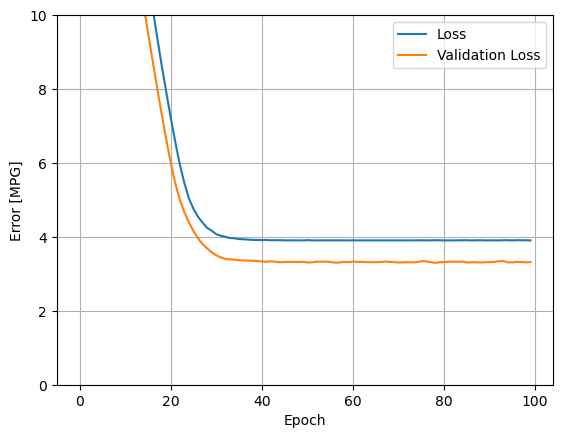

In [27]:
plot_loss(r)

In [28]:
test_results = {}

test_results['horsepower_model'] = horsepower_model.evaluate(test_features['Horsepower'],
                                                             test_labes,
                                                             verbose=0)

In [29]:
x = tf.linspace(.0, 250, 251)

y = horsepower_model.predict(x)

8/8 [==============================] - 0s 408us/step


In [30]:
def plot_horsepower(x, y):
    plt.scatter(train_features['Horsepower'], train_labes, label='Data')
    
    plt.plot(x, y, color='k', label='Predictions')
    
    plt.legend()
    
    plt.xlabel('Horsepower')
    plt.ylabel('MPG')


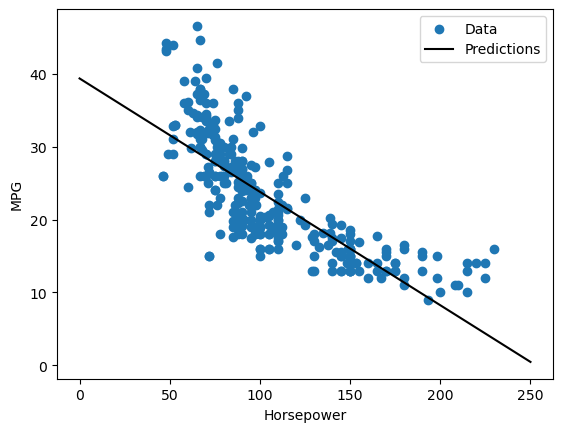

In [31]:
plot_horsepower(x, y)

In [32]:
linear_model = tf.keras.Sequential([
    normalizer,
    tf.keras.layers.Dense(units=1)
])

In [33]:
linear_model.predict(train_features[:10].astype('float32'))

1/1 [==============================] - 0s 19ms/step


array([[ 2.4020183 ],
       [ 0.5860633 ],
       [-1.9967015 ],
       [ 1.990546  ],
       [-0.04582167],
       [-1.9323413 ],
       [-0.04614156],
       [-2.2783952 ],
       [ 0.86667824],
       [ 2.6017885 ]], dtype=float32)

In [34]:
linear_model.layers[1].kernel

<tf.Variable 'dense_1/kernel:0' shape=(9, 1) dtype=float32, numpy=
array([[ 0.31645334],
       [-0.65987015],
       [-0.73168576],
       [ 0.05319417],
       [-0.2712279 ],
       [-0.6572832 ],
       [ 0.68579805],
       [-0.7407972 ],
       [ 0.71276295]], dtype=float32)>

In [35]:
linear_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=.1),
                     loss='mean_absolute_error')

In [36]:
%%time

r = linear_model.fit(train_features.astype('float32'),
                     train_labes,
                     epochs=100,
                     verbose=0,
                     validation_split=.2)

CPU times: user 1.57 s, sys: 101 ms, total: 1.67 s
Wall time: 1.47 s


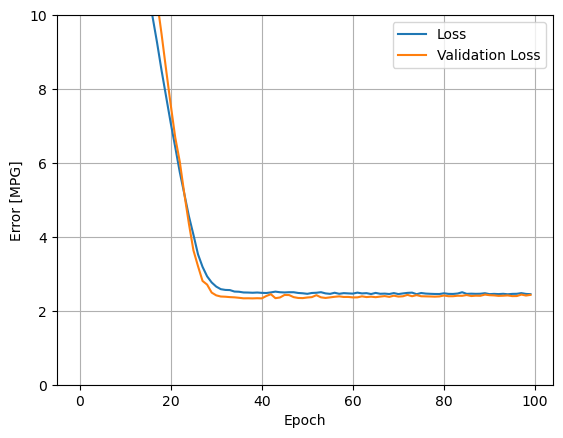

In [37]:
plot_loss(r)

In [38]:
test_results['linear_model'] = linear_model.evaluate(test_features.astype('float32'),
                                                     test_labes,
                                                     verbose=0)

## Regression with Deep Neural Network

In [39]:
def build_n_compile_model(norm):
    model = tf.keras.Sequential([
        norm,
        tf.keras.layers.Dense(64, activation='relu'),
        tf.keras.layers.Dense(64, activation='relu'),
        tf.keras.layers.Dense(1)
    ])
    
    model.compile(optimizer=tf.keras.optimizers.Adam(.001),
                  loss='mean_absolute_error')
    
    return model

In [40]:
dnn_horsepower_model = build_n_compile_model(horsepower_normalizer)

In [41]:
dnn_horsepower_model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 normalization_1 (Normaliza  (None, 1)                 3         
 tion)                                                           
                                                                 
 dense_2 (Dense)             (None, 64)                128       
                                                                 
 dense_3 (Dense)             (None, 64)                4160      
                                                                 
 dense_4 (Dense)             (None, 1)                 65        
                                                                 
Total params: 4356 (17.02 KB)
Trainable params: 4353 (17.00 KB)
Non-trainable params: 3 (16.00 Byte)
_________________________________________________________________


In [42]:
%%time

history = dnn_horsepower_model.fit(train_features['Horsepower'], 
                                   train_labes, 
                                   validation_split=.2, 
                                   verbose=0, 
                                   epochs=100)



CPU times: user 1.78 s, sys: 103 ms, total: 1.89 s
Wall time: 1.61 s


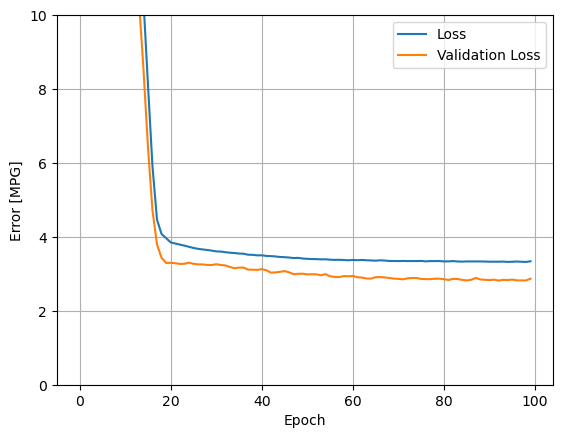

In [43]:
plot_loss(history)

In [44]:
x = tf.linspace(.0, 250, 251)
y = dnn_horsepower_model.predict(x)

8/8 [==============================] - 0s 449us/step


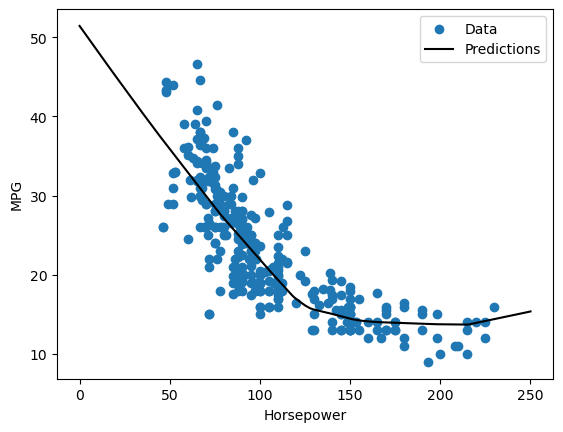

In [45]:
plot_horsepower(x, y)

In [46]:
test_results['dnn_horsepower_model'] = dnn_horsepower_model.evaluate(test_features['Horsepower'],
                                                                     test_labes,
                                                                     verbose=0)

In [47]:
dnn_model = build_n_compile_model(normalizer)
dnn_model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 normalization (Normalizati  (None, 9)                 19        
 on)                                                             
                                                                 
 dense_5 (Dense)             (None, 64)                640       
                                                                 
 dense_6 (Dense)             (None, 64)                4160      
                                                                 
 dense_7 (Dense)             (None, 1)                 65        
                                                                 
Total params: 4884 (19.08 KB)
Trainable params: 4865 (19.00 KB)
Non-trainable params: 19 (80.00 Byte)
_________________________________________________________________


In [48]:
%%time

history = dnn_model.fit(test_features.astype('float32'),
                        train_labes,
                        validation_split=.2,
                        verbose=0,
                        epochs=100)

CPU times: user 1.42 s, sys: 156 ms, total: 1.58 s
Wall time: 1.38 s


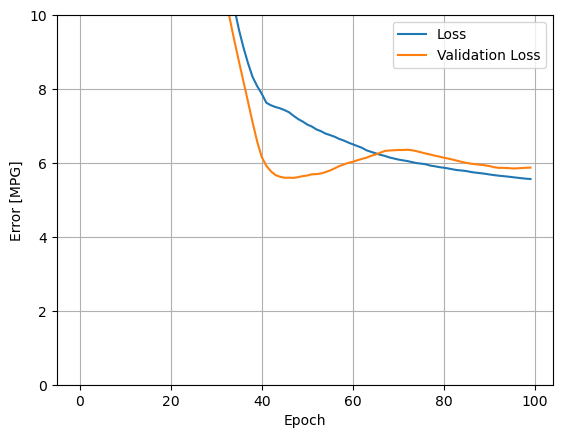

In [49]:
plot_loss(history)

In [51]:
test_results['dnn_model'] = dnn_model.evaluate(test_features.astype('float32'),
                                               test_labes,
                                               verbose=0)

## Performance

In [52]:
pd.DataFrame(test_results, index=['Mean absolute error [MPG]']).T

,Mean absolute error [MPG]
horsepower_model,3.940495
linear_model,2.499171
dnn_horsepower_model,3.455405
dnn_model,8.590885


In [55]:
test_predictions = dnn_model.predict(test_features.astype('float32')).flatten()

3/3 [==============================] - 0s 700us/step


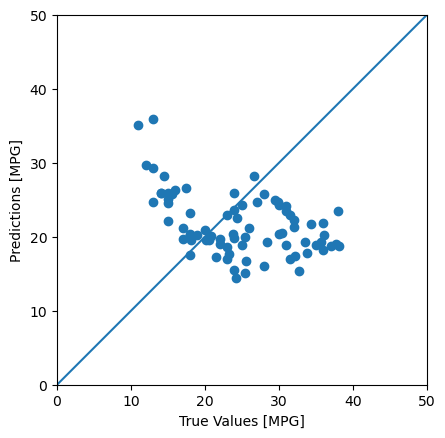

In [57]:
a = plt.axes(aspect='equal')

plt.scatter(test_labes, test_predictions)

plt.xlabel('True Values [MPG]')
plt.ylabel('Predictions [MPG]')

lims = [0, 50]

plt.xlim(lims)
plt.ylim(lims)

plt.plot(lims, lims)

Text(0, 0.5, 'Count')

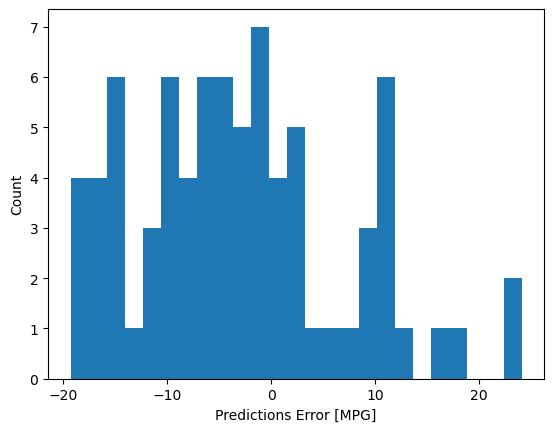

In [58]:
error = test_predictions - test_labes

plt.hist(error, bins=25)

plt.xlabel('Predictions Error [MPG]')

plt.ylabel('Count')

In [59]:
dnn_model.save('./models/dnn_model.keras')